## Deriving the Black-Scholes-Merton Equation
Based on and transcribed from the very informative YouTube video, [FN452 Deriving the Black-Scholes-Merton Equation](https://www.youtube.com/watch?v=IynFtIQ6HaI) by Nattakit Chokwattananuwat. This document is meant to give an easy-to-understand overview of the derivation of the Black-Scholes-Merton equation while still not skipping out on the main mathematical details. For an intuitive overview of this equation, see the [README.md in this folder](README.md).

## Introduction

The Black-Scholes-Merton equation is used to price a European call or put option on a stock paying no dividends. The equation is as follows:

$$\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2S^2\frac{\partial^2 V}{\partial S^2} + rS\frac{\partial V}{\partial S} - rV = 0$$

where $V$ is the price of the option. This equation expresses $V$ as a function of time $t$ and stock price $S$. 



### Assumptions
The derivation will assume ideal market conditions, which are described by the following:
1. Stock price $S$ follows a stochastic process. Historical price cannot be used to predict future movement.
2. No dividends and transaction costs.
3. Risk-free rate (short-term interest rates) and volatility of stock price is known and constant.
4. Can borrow fractions of stock
5. Short selling is allowed

### Geometric Brownian Motion
We begin by examining a generalized Wiener process known as arithmetic Brownian motion (ABM):

$$\partial S = \mu dt + \sigma dz$$

ABM shows that changes in stock price $S$ come from two terms:
1. The drift term $\mu dt$ which represents the expected return of the stock ($\mu$) given a very small change in time ($dt$). 
2. The variance term $\sigma dz$ which represents volatility in the stock price. The uncertainty comes from $dz = \epsilon \sqrt{dt}$ where $\epsilon \sim \mathcal{N}(0, 1)$.

However, there are a couple flaws with ABM: this model of linear growth does not include compounding effects, and the stock price can also become negative.

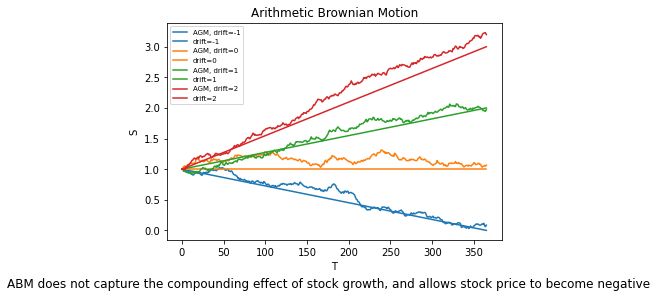

In [53]:
# Based on code from https://www.youtube.com/watch?v=QIM12cvCu4c
import numpy as np
import math 
import matplotlib.pyplot as plt

class ArithmeticBrownianMotion:
    def __init__(self, drift, volatility, delta_t, initial_asset_price):
        self.drift = drift 
        self.volatility = volatility 
        self.delta_t = delta_t
        self.current_asset_price = initial_asset_price 
        self.asset_prices = [initial_asset_price]
    
    def time_step(self):
        dz = np.random.normal(0, math.sqrt(self.delta_t)) 
        dS = self.drift * self.delta_t + self.volatility * dz 
        self.current_asset_price += dS
        self.asset_prices.append(self.current_asset_price)

processes = []
for i in range(-1, 3):
    processes.append(ArithmeticBrownianMotion(i, 0.3, 1/365, 1))

for process in processes:
    tte = 1
    while tte - process.delta_t > 0:
        process.time_step()
        tte -= process.delta_t 

x = np.linspace(0, 365, 365)
for p in processes:
    pplot = plt.plot(np.arange(0, len(p.asset_prices)), p.asset_prices, label=f'AGM, drift={p.drift}')
    y = 1 + p.drift/365*x
    _ = plt.plot(x, y, label=f'drift={p.drift}', color=pplot[0].get_color())
plt.legend(loc='upper left', prop={'size': 7})
plt.xlabel('T')
plt.ylabel('S')
plt.title('Arithmetic Brownian Motion')
txt="ABM does not capture the compounding effect of stock growth, and allows stock price to become negative"
plt.figtext(0.5, -0.04, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

To address these problems, we can use geometric Brownian motion (GBM) instead:

$$\partial S = \mu S dt + \sigma S dz$$

By adding $S$ to each term, the equation accounts for the compounding effect of stock growth and introduces absorbing barriers that prevent the stock price from becoming negative. 

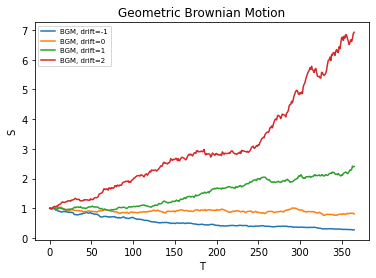

In [57]:
class GeometricBrownianMotion:
    def __init__(self, drift, volatility, delta_t, initial_asset_price):
        self.drift = drift 
        self.volatility = volatility 
        self.delta_t = delta_t
        self.current_asset_price = initial_asset_price 
        self.asset_prices = [initial_asset_price]
    
    def time_step(self):
        dz = np.random.normal(0, math.sqrt(self.delta_t)) 
        dS = self.drift * self.current_asset_price * self.delta_t + self.volatility * self.current_asset_price * dz 
        self.current_asset_price += dS
        self.asset_prices.append(self.current_asset_price)

processes = []
for i in range(-1, 3):
    processes.append(GeometricBrownianMotion(i, 0.3, 1/365, 1))

for process in processes:
    tte = 1
    while tte - process.delta_t > 0:
        process.time_step()
        tte -= process.delta_t 

x = np.linspace(0, 365, 365)
for p in processes:
    pplot = plt.plot(np.arange(0, len(p.asset_prices)), p.asset_prices, label=f'BGM, drift={p.drift}')
    y = 1 + p.drift/365*x
    # _ = plt.plot(x, y, label=f'drift={p.drift}', color=pplot[0].get_color())
plt.legend(loc='upper left', prop={'size': 7})
plt.xlabel('T')
plt.ylabel('S')
plt.title('Geometric Brownian Motion')
plt.show()

### Ito's Lemma

Recall from the Introduction that the price of the option $V$ is a function of a stochastic process $S$ and $t$. Ito's Lemma tells us that if $V(S, t)$ is a function of a stochastic process, $dV$ should behave as follows:

$$dV = \frac{\partial V}{\partial S}dS + \frac{\partial V}{\partial t}dt + \frac{1}{2}\frac{\partial^2 V}{\partial S^2}dS^2 + \frac{1}{2}\frac{\partial^2 V}{\partial t^2}dt^2 + \frac{\partial^2 V}{\partial t \partial S}dt dS$$

### Delta-Hedged Portfolio
Our portfolio $\Pi$ consists of a long position in a call $V$ and a short position in $\Delta$ shares of stock $S$. 

$$\Pi = V - \Delta S$$

## The Derivation

### Finding $dS^2$
We know that GBM is modeled by $dS = \mu S dt + \sigma S dz$. We want to find $dS^2$.

$$
\begin{aligned}
dS^2 = \mu^2 S^2 dt^2 + \sigma^2 S^2 dz^2 + 2\mu\sigma S^2 dzdt
\end{aligned}
$$

Recall that $dz = \epsilon \sqrt{t}$, so $dz^2$ can be approximated by $dt$. We can also approximate $dt^2 \approx 0$ since $dt$ is very small, and $dz dt = dt ^ {3/2} \approx 0$, so the first and third term disappear, leaving us with:
$$
dS^2 = \sigma^2 S^2 dt
$$

### Simplifying $dV$
Consider the equation we got from Ito's Lemma above. 

$$dV = \frac{\partial V}{\partial S}dS + \frac{\partial V}{\partial t}dt + \frac{1}{2}\frac{\partial^2 V}{\partial S^2}dS^2 + \frac{1}{2}\frac{\partial^2 V}{\partial t^2}dt^2 + \frac{\partial^2 V}{\partial t \partial S}dt dS$$

Again, we can use the approximation $dt^2\approx 0$ to cancel out the fourth term. Expanding the $dt dS$ part of the last term, we get 

$$
\begin{aligned}
dt dS &= dt (\mu S dt + \sigma S dz)\\
    &= \mu S dt^2 + \sigma S dz dt
\end{aligned}
$$

Again we approximate $dt^2\approx 0$ and $dzdt = dt^{3/2} \approx 0$, so this entire last term can be ignored as well. We can also substitute $dS^2 = \sigma^2 S^2 dt$ into the third term. After all these simplifications, we get:

$$dV = \frac{\partial V}{\partial S}dS + \frac{\partial V}{\partial t}dt + \frac{1}{2}\frac{\partial^2 V}{\partial S^2} \sigma^2 S^2 dt$$


### Incorporating the Delta-Hedged Portfolio
Our equation for the delta-hedged portfolio was given by $\Pi = V - \Delta S$. We are interested in the change in the value of the portfolio as $S$ changes, so we can use the equation $$d\Pi = dV - \Delta dS$$

Substituting for $dV$ from above, and noting that $\Delta = \frac{\partial V}{\partial S}$, we get

$$
\begin{aligned}
d\Pi &= (\frac{\partial V}{\partial S}dS + \frac{\partial V}{\partial t}dt + \frac{1}{2}\frac{\partial^2 V}{\partial S^2} \sigma^2 S^2 dt) - \Delta dS \\
    &= \cancel{\frac{\partial V}{\partial S}dS} + \frac{\partial V}{\partial t}dt + \frac{1}{2}\frac{\partial^2 V}{\partial S^2} \sigma^2 S^2 dt - \cancel{\frac{\partial V}{\partial S} dS} \\
    &= \frac{\partial V}{\partial t}dt + \frac{1}{2}\frac{\partial^2 V}{\partial S^2} \sigma^2 S^2 dt\\
\end{aligned}
$$

Now let's examine the portfolio. The portfolio constructed is hedged and therefore should return the risk-free rate, giving us $d\Pi = r\Pi dt = r (V - \Delta S) dt$. Substituting into our equation, we get:

$$
\begin{aligned}
r (V - \Delta S) dt &= \frac{\partial V}{\partial t}dt + \frac{1}{2}\frac{\partial^2 V}{\partial S^2} \sigma^2 S^2 dt\\
(rV - \frac{\partial V}{\partial S} rS) \cancel{dt} &= \frac{\partial V}{\partial t}\cancel{dt} + \frac{1}{2}\frac{\partial^2 V}{\partial S^2} \sigma^2 S^2 \cancel{dt}\\
\end{aligned}
$$

Rearranging terms, this yields the coveted Black-Scholes-Merton partial differential equation.

$$\frac{\partial V}{\partial S} rS + \frac{\partial V}{\partial t} + \frac{1}{2}\frac{\partial^2 V}{\partial S^2} \sigma^2 S^2 - rV = 0$$

Solving this equation yields the Black-Scholes-Merton model. For an intuitive overview of this equation, see the [README.md in this folder](README.md).

### Sources
- [FN452 Deriving the Black-Scholes-Merton Equation](https://www.youtube.com/watch?v=IynFtIQ6HaI), Nattakit Chokwattananuwat (*main source*)
- [The Easiest Way to Derive the Black-Scholes Model](https://www.youtube.com/watch?v=NHvQ5CSSgw0), Perfiliev Financial Training
- [Black-Scholes PDE Derivation in 4 minutes](https://www.youtube.com/watch?v=6LhV32OIZ1Y&t=154s), QuantPy
- [Arithmetic Brownian Motion in Python](https://www.youtube.com/watch?v=QIM12cvCu4c), Quant Guild